# Diving into BoardGameGeek
> What are the key insights from 19M game reviews?

- toc: false
- branch: master
- badges: true
- comments: true
- author: Jesse van Elteren
- image: images/
- categories: []

![](images/bgg.jpg)

If you are into boardgames, you probably have a wishlist of potential games to buy. I admit that it's a bit of a guilty pleasure of mine. Many people turn to [BoardGameGeek (BGG)](https://boardgamegeek.com/), which is a great site with many active users reviewing games. I used the BGG API to download:
* 410K users giving out 19M reviews
* 22K games (game type, complexity, minimum age, game duration etc)

I wanted to see what affects the final rating of a game. 
TLDR: We can determine certain predictors for the rating a game receives:
* Newer games receive higher ratings
* More complex games receive higher ratings
* Less active users give higher ratings
* Some games are rated in a suspicious way

In total this explains roughly 50% of the variation in ratings.

Let's dive in!

### The users and ratings

In [106]:
# hide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import warnings
from pandas.errors import DtypeWarning
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

from utils.database import DB
from aocutils.datascience import nan_inspect, save, load

warnings.simplefilter(action='ignore', category=DtypeWarning)
pd.options.display.max_rows = 200
pd.options.display.float_format = "{:,.2f}".format


In [107]:
# hide
def types(data, y_col):
    # split columns into sorted numerical and categorical based on correlation with y_col
    corr = data.corr()[y_col]
    corr = corr.sort_values(ascending=False)
    num_x = list(corr.index)[1:]
    cat_x = [col for col in data.columns if data[col].dtype == 'object']
    cat_x.sort(key = lambda x: -correlation_ratio(data[x],data[y_col]))
    return num_x, cat_x

def split(data, y_col):
    # splits dataset into x and y dataset
    data_x = data.drop([y_col], axis=1)
    data_y = data.loc[:,y_col]
    return data_x, data_y

# metric for correlation of categorial features with target. Used for sorting features in displaying
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

def regr(x, y, s=0.01):
    # make a regression. s is the point size
    regr = linear_model.LinearRegression()
    x = x.values.reshape(-1, 1)
    regr.fit(x, y)
    print(f'r2: {regr.score(x, y):.2f}')
    # plot it as in the example at http://scikit-learn.org/
    plt.scatter(x, y,  color='black',s=s)
    plt.plot(x, regr.predict(x), color='blue', linewidth=3)
    return plt

In [108]:
# hide
db = DB('bgg2022.db')
df = pd.read_csv('games_detailed_info.csv')
y = 'average'

[('games', 21839), ('reviews', 18964807)]


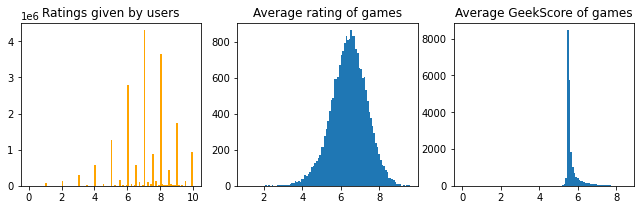

In [109]:
# hide_innput
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(11,3))
ax1.hist(db.df("SELECT rating FROM reviews").astype(float), bins=100, color='orange')
ax1.title.set_text('Ratings given by users')
ax2.hist(df[y], bins=100)
ax2.title.set_text('Average rating of games')
ax3.hist(df['bayesaverage'], bins=100);
ax3.title.set_text('Average GeekScore of games')

Users give ratings that are often rounded off, i.e give a 8 instead of a 8.23, that's why you see the spikes on the leftmost chart. Looking at the games, we see a nice normal distribution with a mean of 6.4 (and for the purists: no I've got no intention of testing for normality here😊).

In addition BGG has it's own Geekscore, which penalizes games with few reviews. You see that distribution is much more 'squashed', with an hardly any games above a 6.

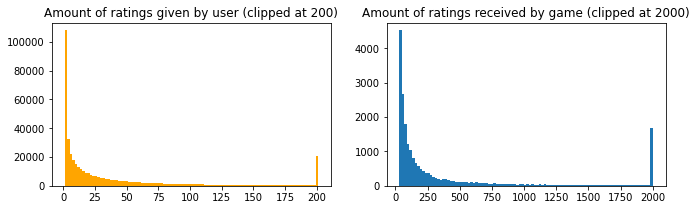

In [26]:
# hide_innput
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,3))
users = db.df("SELECT user, COUNT(*) as count, AVG(rating) as average FROM reviews GROUP BY user")
ax1.hist(users['count'].clip(0,201), bins=100, color='orange')
ax1.title.set_text('Amount of ratings given by user (clipped at 200)')

sql = """
    SELECT g.name, g.ID, COUNT(*) as count, AVG(r.rating) as average 
    FROM reviews r
    JOIN games g
    ON g.ID = r.ID
    GROUP BY r.ID
"""
games = db.df(sql)
ax2.hist(games['count'].clip(0,2001), bins=100)
ax2.title.set_text('Amount of ratings received by game (clipped at 2000)')

In [27]:
# hide
(len(users.loc[users['count']==1]) / len(users),
sum(users.loc[users['count']==1]['count']) / sum(users['count']),
len(users.loc[users['count']>=201]) / len(users),
sum(users.loc[users['count']>=201]['count']) / sum(users['count']))
# len(games.loc[games['count']<100]) / len(users)

(0.19440137979148095,
 0.004231627561514336,
 0.04901215069183365,
 0.4274852889354476)

In [28]:
# hide
(len(games.loc[games['count']<100]) / len(games),
sum(games.loc[games['count']<100]['count']) / sum(games['count']),
len(games.loc[games['count']>=2001]) / len(games),
sum(games.loc[games['count']>=2001]['count']) / sum(games['count']))

(0.44443426896835936,
 0.02854898549718961,
 0.07628554420989972,
 0.7255024530436824)

For the pareto fans amount you:
* 19% of **users** only leave 1 review. However, these reviews only account for 0.5% of all reviews
* 5% of users (20k) leave more than 200 reviews. Together they account for 27% of reviews
* 44% of **games** reveive less than 100 reviews. However, these reviews only account of 6% of all reviews.
* 7% of games have 2000 or more reviews, However they make up 39% of all reviews

### Rating development over the years

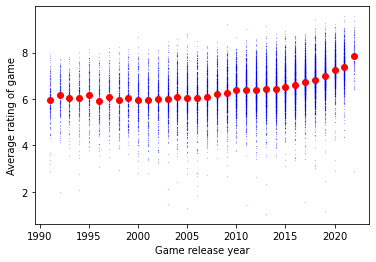

In [8]:
# hide_input
years = df.loc[(df['yearpublished'] > 1990) & (df['yearpublished'] < 2023)]
ax1 = plt.axes()
ax1.scatter(years['yearpublished'], years[y],  color='blue',s=0.01)
ax1.set_xlabel('Game release year')
ax1.set_ylabel('Average rating of game')

years = years.groupby('yearpublished').agg('mean').reset_index()
ax1.scatter(years['yearpublished'], years['average'], color='red');

There seems to be an increase in the ratings over the years. Now are games just better of is there a tendency to rate new games higher? I've composed this dataset already twice in previous years, this now finally pays off:

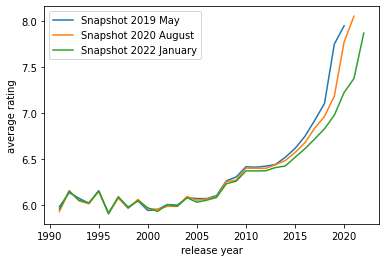

In [9]:
# hide_input
cut = 1990
versions = [('archive/games_detailed_info_2019.csv', 'Snapshot 2019 May'),
            ('archive/games_detailed_info_2020.csv', 'Snapshot 2020 August'),
            ('games_detailed_info.csv', 'Snapshot 2022 January')]
for path, label in versions:
    dfold = pd.read_csv(path)
    df2 = dfold.loc[(dfold['yearpublished'] > cut) & (dfold['yearpublished'] < 2023)]
    yearsold = df2.groupby('yearpublished').agg('mean').reset_index()
    plt.plot(yearsold['yearpublished'], yearsold['average'], label=label)
plt.ylabel('average rating')
plt.xlabel('release year')

plt.legend();

It's a mix of improved quality and hype:
* Scores have been climbing since 2005. There is a rough consensus that boardgames have improved in quality.
* As you see the 3 snapshots diverge around 2015. This is a 'hype' effect, where the early adopters score a new/upcoming games higher. For any year, the blue line (the ratings from the dataset in 2019) scores highest, after the orange (2020) and lowest in the most recent version of the dataset (2022). Games from 2020 where rated with 7.8 in 2020, but two years later that has dropped to 7.2 and now games from 2022 are rated with 7.8! When games are about 5 years old the 'hype' effect is more or less gone and games reach a stable score (around 2014 there is no difference anymore). 

### Relation between complexity of games and ratings

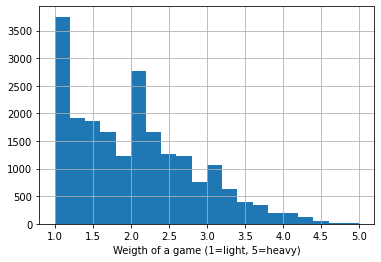

In [10]:
# hide_input
df2 = df.loc[df['averageweight'] > 0]
ax = df2['averageweight'].hist(bins=20)
ax.set_xlabel('weight of a game (1=light, 5=heavy)');

BGG has a weight metric, which means how complex a game is. To get a feel what a number means, here some examples:
* Monopoly: 1.3
* Catan: 2.3
* Chess: 3.7
You see that most of the games have a fairly low weight.

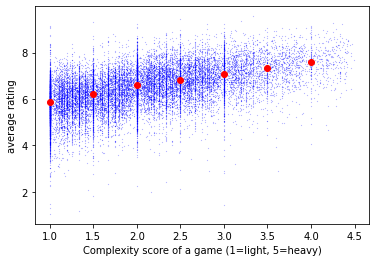

In [29]:
# hide_input
s = 0.01
ax1 = plt.axes()
ax1.scatter(df2['averageweight'], df2[y],  color='blue',s=s)

df2.loc[:,'complexity'] = (df2['averageweight'] // 0.5 * 0.5).copy()
df2 = df2.loc[df2['complexity']<4.5]
complexity = df2.groupby('complexity').agg('mean').reset_index()
ax1.scatter(complexity['complexity'], complexity['average'], color='red')
ax1.set_xlabel('Complexity score of a game (1=light, 5=heavy)');
ax1.set_ylabel('average rating');

There is a relation between the weight/complexity of the game and the score. More complex games get higher scores, it's almost a 1 point difference between a game with weight 1 and 5!

### 'Experienced' users giving lower scores

In [12]:
# hide
users.sort_values('count', inplace=True)
users['cumsum'] = users['count'].cumsum()
totalreviews = sum(users['count'])
tertile = totalreviews //3
first_tertile = users[users['cumsum'] > tertile].iloc[0]['count']
second_tertile = users[users['cumsum'] > 2*tertile].iloc[0]['count']
first_tertile, second_tertile

(88, 273)

In [13]:
# hide
new = users.loc[users['count']< first_tertile]
middle = users.loc[(users['count']>= first_tertile) & (users['count']<=second_tertile)]
experienced = users.loc[users['count']>second_tertile]
assert len(new) + len(middle) + len(experienced) == len(users)

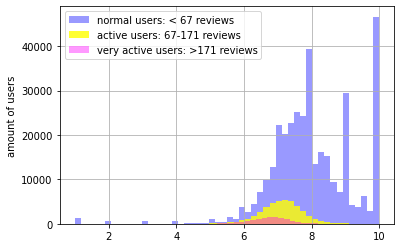

In [14]:
# hide_input
new['average'].hist(bins=50, fc=(0, 0, 1, 0.4), label='normal users: < 67 reviews')
middle['average'].hist(bins=50, fc=(1, 1, 0, 0.8), label='active users: 67-171 reviews')
experienced['average'].hist(bins=50, fc=(1, 0, 1, 0.4), label='very active users: >171 reviews')
plt.ylabel('amount of users')
plt.legend();

In [15]:
# hide
for i in [new, middle, experienced]:
    print(i['average'].mean())
len(experienced)/len(users)
(sum(new['average'] == 10)) / len(users)

8.02995376296331
7.111292974103985
6.74890022410223


0.11120935235068408

Here you see the average rating that different user groups are giving. I've split the population in 3 parts that all account for 33% of the reviews. The very active group gives lower scores (6.9 avg) compared to the active users (7.2 avg) and the normal users (8.1 avg). 
The very active users only make up of 6% the population (note it's a small area), they do give out 33% of the reviews!

Finally, it's notable that 11% of all users give a 10 on average, which accounts for 0.5% of all reviews. You can make a case for filtering these reviews out.

### What is the best game?
While doing this project so many ideas came to mind on how a ranking could be defined, e.g.:
* Excluding reviews given by infrequent users (e.g. users that have rated < 20 games)
* Excluding games that are not reviewed often
* Training a model that the release year into account. This approach I abandoned, since some new games are truly better. The only thing you want to account for is removing the 'hype' effect. This is possible by just excluding the most recent games from the analysis.
* Training a model that takes the weight into account, such that the 'complexity bonus' games receive is taken away. I do this by interpreting the residuals of the model as an indication of quality (what the model cannot explain by complexity must be the quality).
* Training a model that takes the average user rating into account. This way you could see what games users rate higher compared to the other games they have rated. You could even look at z scores of users.

Let me show you some of the outcomes

In [158]:
# hide
df = pd.read_csv('games_detailed_info.csv')
print(len(df))
# clip some values to make plotting easier
df['minplaytime'] = df['minplaytime'].clip(0,500)
df['maxplaytime'] = df['minplaytime'].clip(0,500)
df['maxplayers'] = df['minplaytime'].clip(0,20)
df['yearpublished'] = df['yearpublished'].clip(lower=1970, upper=2030, axis=0)
# I'm filtering out the hype years here
df = df.loc[df['yearpublished'] < 2018].reset_index()
df.rename(columns={'primary':'name', 'id':'ID'}, inplace=True)
print(len(df))

21631
17362


In [160]:
#hide
reviews = pd.read_csv('bgg-19m-reviews.csv',index_col=0)
merged_reviews = reviews.merge(users,how='left',on='user',suffixes=('','user'))
merged_reviews['only_one_review'] = (merged_reviews['count'] == 1)*1
merged_reviews.head()

,user,rating,comment,ID,name,count,average,only_one_review
0,Torsten,10.00,NaN,30549,Pandemic,"1,460.00",6.87,0
1,mitnachtKAUBO-I,10.00,Hands down my favorite new game of BGG CON 200...,30549,Pandemic,397.00,6.66,0
2,avlawn,10.00,I tend to either love or easily tire of co-op ...,30549,Pandemic,"1,038.00",6.44,0
3,Mike Mayer,10.00,NaN,30549,Pandemic,729.00,6.81,0
4,Mease19,10.00,This is an amazing co-op game. I play mostly ...,30549,Pandemic,422.00,7.14,0


In [173]:
# hide
condition = merged_reviews['count']>10
merged_games = merged_reviews.loc[condition].groupby(['ID', 'name'])[['rating', 'average', 'only_one_review', 'count']].agg( avg_rating= ('rating', 'mean'),
                                                                                                user_avg_rating= ('average','mean'), 
                                                                                                num_inactive= ('only_one_review','sum'), 
                                                                                                num_reviews=('rating', 'count'), 
                                                                                                user_median_review_count= ('count', 'median'))
merged_games.reset_index(inplace=True)

In [231]:
# hide_input

df_only_experienced = df.merge(merged_games,how='left',on='ID',suffixes=('', 'review'))
df_only_experienced['proportion_inactive'] = df_only_experienced['num_inactive'] / df_only_experienced['num_reviews']
df_only_experienced.sort_values('avg_rating', ascending=False, inplace=True)
df_only_experienced.set_index(pd.RangeIndex(start=1, stop=len(df_only_experienced)+1, step=1), inplace=True)

# filter out games with < 1000 reviews
print(len(df_only_experienced))
df_only_experienced = df_only_experienced.loc[df_only_experienced['num_reviews']>1000]
print(len(df_only_experienced))


17362
2362


In [232]:
df_only_experienced[['name', 'avg_rating', 'averageweight', 'yearpublished']][:10]

,name,avg_rating,averageweight,yearpublished
9,Gloomhaven,8.64,3.87,2017
16,Twilight Imperium: Fourth Edition,8.59,4.26,2017
20,Pandemic Legacy: Season 1,8.56,2.83,2015
37,War of the Ring: Second Edition,8.45,4.17,2012
45,Gaia Project,8.43,4.37,2017
53,Star Wars: Rebellion,8.38,3.73,2016
55,Terraforming Mars,8.36,3.24,2016
57,Too Many Bones,8.36,3.84,2017
59,Through the Ages: A New Story of Civilization,8.35,4.41,2015
60,Aeon's End: War Eternal,8.34,2.93,2017


This corresponds more or less to the [top games listed on BGG](https://boardgamegeek.com/browse/boardgame). If you check out the average weight you see that these are all pretty heavy games. 

But I don't have time to play games that are very complex and take many hours, so let's account for the complexity, such that great lighter games will pop up more. I trained a tree based model (LGBM) with a r2 of 0.3. It's only 0.3, but that does mean that 30% of the variation in the rating is explained by the complexity!

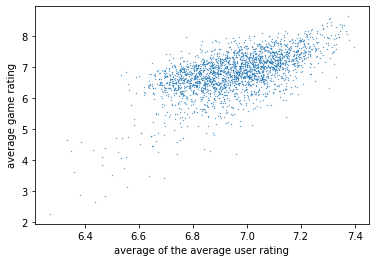

In [233]:
# hide
# Another thing I want to correct for is the effect that if games are rated by users that generally give lower scores, this has an effect on the rating of the game.
# didnt really work out, since the outliers that are rated by grumps get promoted to the top
plt.scatter(df_only_experienced['user_avg_rating'], df_only_experienced['avg_rating'],s=0.1)
plt.xlabel('average of the average user rating')
plt.ylabel('average game rating');

In [234]:
# hide
df_only_experienced['delta_rating_avg_user_rating'] = df_only_experienced['avg_rating'] - df_only_experienced['user_avg_rating']
df_only_experienced.sort_values('delta_rating_avg_user_rating', ascending=False, inplace=True)
df_only_experienced[['name', 'avg_rating', 'delta_rating_avg_user_rating', 'averageweight', 'yearpublished']][:10]

,name,avg_rating,delta_rating_avg_user_rating,averageweight,yearpublished
16,Twilight Imperium: Fourth Edition,8.59,1.28,4.26,2017
9,Gloomhaven,8.64,1.26,3.87,2017
20,Pandemic Legacy: Season 1,8.56,1.26,2.83,2015
271,Shikoku 1889,7.98,1.20,3.91,2004
37,War of the Ring: Second Edition,8.45,1.14,4.17,2012
45,Gaia Project,8.43,1.14,4.37,2017
59,Through the Ages: A New Story of Civilization,8.35,1.07,4.41,2015
154,Triumph & Tragedy: European Balance of Power 1...,8.11,1.05,3.34,2015
65,Kingdom Death: Monster,8.33,1.03,4.26,2015
60,Aeon's End: War Eternal,8.34,1.03,2.93,2017


### Minimal model


In [235]:
# hide
# only keep relevant or minimal features
minimal = ['average', 'averageweight']
df_preprocessed = df_only_experienced[minimal]


I've made two models: one which takes only 3 features into account: the complexity, the 

In [236]:
# hide
def train(df_preprocessed, y_col):
    train, test = train_test_split(df_preprocessed, test_size=0.2)
    x, y = split(train, y_col)
    x_test, y_test = split(test, y_col)
    print(len(df_preprocessed), len(train), len(test))
    
    params = {'num_leaves':10, 'min_data_in_leaf':100, 'max_depth':5}
    model = lgb.LGBMRegressor(objective='regression',random_state=112, **params) #
    model = model.fit(x,y)
    print('train score', model.score(x,y))
    print('test score', model.score(x_test,y_test))
    data = {'train_x':x, 'train_y':y, 'test_x':x_test, 'test_y':y_test, 'names':df['name'], 'full_df':df_preprocessed}
    save(model, 'models/lightgbm.pickle')
    save(data, 'models/data.pickle')
    return model

model = train(df_preprocessed, 'average')

2362 1889 473
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
train score 0.38199094802072553
test score 0.297485984450262


In [237]:
# hide
preds = model.predict(df_preprocessed.drop('average',axis=1))
df2 = df_only_experienced.copy()
df2['preds'] = preds
df2['residual'] = df2['average'] - df2['preds']
df2.sort_values('residual', inplace=True, ascending=False)
df2.set_index(pd.RangeIndex(start=1, stop=len(df2)+1, step=1), inplace=True)

I've taken 2000 reviews as a minimum for the game to be included. This results in the following top 10:

In [238]:
# hide_input
df_excomplex = df2.loc[(df2['usersrated'] > 2000) & (df2['averageweight'] > 0.9)][['name', 'yearpublished', 'average', 'user_avg_rating', 'preds', 'residual', 'usersrated', 'averageweight']][:10]
df_excomplex.set_index(pd.RangeIndex(start=1, stop=len(df_excomplex)+1, step=1), inplace=True)
df_excomplex

,name,yearpublished,average,user_avg_rating,preds,residual,usersrated,averageweight
1,Monikers,2015,7.80,7.12,6.02,1.77,4122,1.06
2,Telestrations: 12 Player Party Pack,2011,7.75,7.07,6.02,1.73,2390,1.07
3,KLASK,2014,7.64,7.06,6.02,1.62,6837,1.08
4,Crokinole,1970,7.95,7.01,6.39,1.56,13455,1.25
5,Time's Up! Title Recall!,2008,7.71,6.96,6.25,1.46,3266,1.19
6,Pandemic Legacy: Season 1,2015,8.59,7.30,7.17,1.43,45064,2.83
7,Telestrations,2009,7.40,7.04,6.02,1.37,14122,1.08
8,Rhino Hero: Super Battle,2017,7.28,7.10,6.02,1.26,4022,1.11
9,Codenames,2015,7.60,7.24,6.35,1.24,74456,1.28
10,Azul,2017,7.80,7.30,6.58,1.22,62860,1.76


There are a lot of dexterity and party games in the top, which are also often not so complex. Pandemic Legacy scores high even while being fairly complex. If we filter out the easiest games we get the following list, of which I know the first 4 are absolute great games

In [239]:
# hide_input
df_morecomplex = df2.loc[(df2['usersrated'] > 2000) & (df2['averageweight'] > 1.5)][['name', 'yearpublished', 'average', 'user_avg_rating', 'preds', 'residual', 'usersrated', 'averageweight']][:10]
df_morecomplex.set_index(pd.RangeIndex(start=1, stop=len(df_morecomplex)+1, step=1), inplace=True)
df_morecomplex


,name,yearpublished,average,user_avg_rating,preds,residual,usersrated,averageweight
1,Pandemic Legacy: Season 1,2015,8.59,7.30,7.17,1.43,45064,2.83
2,Azul,2017,7.80,7.30,6.58,1.22,62860,1.76
3,Aeon's End: War Eternal,2017,8.38,7.31,7.16,1.22,4061,2.93
4,Mythic Battles: Pantheon,2017,8.43,7.35,7.23,1.20,2763,3.03
5,Patchwork,2014,7.64,7.27,6.46,1.18,52225,1.62
6,Star Realms: Colony Wars,2015,7.85,7.20,6.67,1.17,6719,1.90
7,7 Wonders Duel,2015,8.11,7.34,6.97,1.14,69528,2.22
8,Dominion (Second Edition),2016,7.90,7.20,6.84,1.06,5642,2.17
9,Deception: Murder in Hong Kong,2014,7.49,7.15,6.44,1.05,17927,1.59
10,Terraforming Mars,2016,8.42,7.35,7.37,1.05,74269,3.24


### Full model

Finally I've also trained a model on multiple variables including what type of game it is and the year of publication. I did remove variables like amount of comments which smells a bit like data leakage. This model gets an r2 of almost 0.6, meaning that over 50% in the variation between the of the rating is determined by these variables. Below you see the impact of the most important variables with the wonderful shap package

In [240]:
# hide
# only keep relevant or minimal features

relevant = ['avg_rating', 'yearpublished', 'minplayers', 'maxplayers',
        'minplaytime',
       'maxplaytime', 'minage', 'boardgamecategory', 'boardgamemechanic', 'boardgamefamily',
       'averageweight', 'proportion_inactive'
       ]
df_preprocessed = df_only_experienced[relevant]

In [241]:
# hide
df_preprocessed = df_only_experienced[relevant]

chars = "[]'\""
# df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_,]+', '', x))

onehot = ['boardgamecategory', 'boardgamemechanic','boardgamefamily']
onehot = [col for col in onehot if col in df_preprocessed.columns]
for cat in onehot:
    # df[cat] = df[cat].str.replace('[/]+', ",", regex=True)
    df_preprocessed.loc[:,cat] = df_preprocessed[cat].str.replace('[^A-Za-z0-9_,]+', "", regex=True).copy()
    onehotencoded = df_preprocessed[cat].str.get_dummies(sep=',',)
    onehotencoded.fillna(0, inplace=True)
    print(cat, len(onehotencoded.columns))
    df_preprocessed = pd.concat([df_preprocessed.drop(cat, axis=1), onehotencoded], axis=1)
    # some columns like Deduction are duplicated, since they appear in both category and mechanic
    df_preprocessed = df_preprocessed.loc[:,~df_preprocessed.columns.duplicated()]
print(len(df_preprocessed), len(df_preprocessed.dropna(axis=0)))
model = train(df_preprocessed.dropna(axis=0), 'avg_rating')




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


boardgamecategory 83
boardgamemechanic 184
boardgamefamily 1818
2362 2362
2362 1889 473
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
train score 0.600332393512702
test score 0.6182815343184014


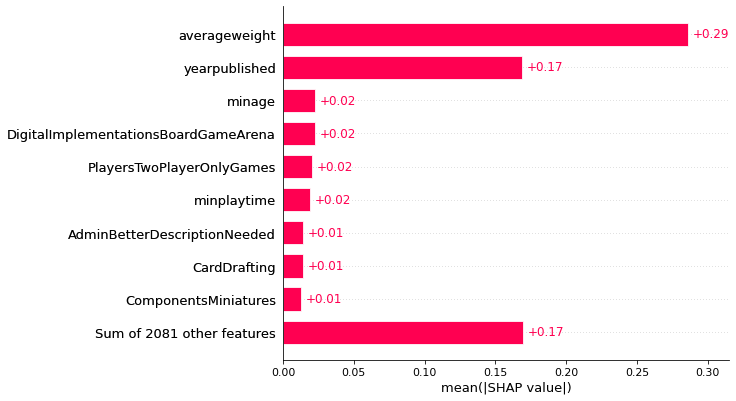

In [242]:
# hide_input
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_preprocessed.drop('avg_rating', axis=1))
# visualize the first prediction's explanation
# summarize the effects of all the features
shap.plots.bar(shap_values)

As expected the weight/complexity and year of publication are great predictors of the rating.  In addition certain categories also have a small impact on the score. In some more detail:

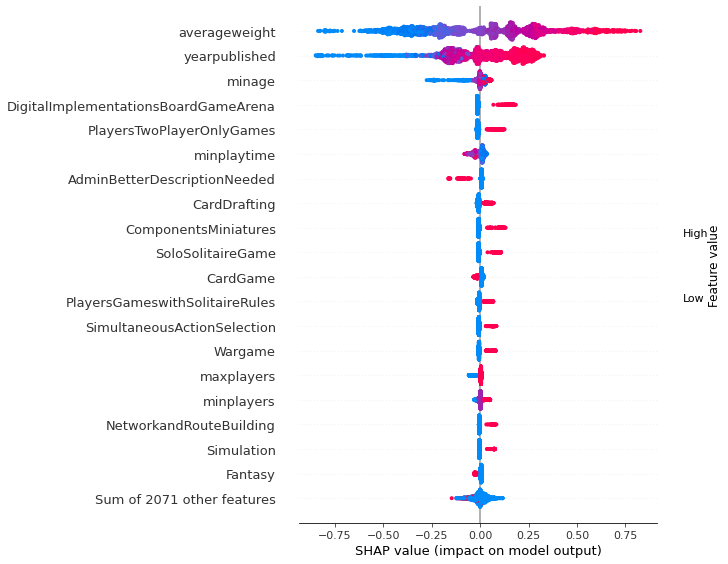

In [243]:
# hide_input
shap.plots.beeswarm(shap_values, max_display=20)

With all the talk about explainable AI these type of analysis are definitely a step in the right direction.
They can be a bit hard to read. All the dots represent games, and if they are on the right side it means the impact on the model was positive.,

Try saying it out loud: 'if averageweight is high (red), then the impact on the model is positive. For dice rolling that means, if dice rolling is high (red), than the impact on the model is negative.

That's it, hope you enjoyed this analysis!